In [258]:
# JJ XOR Network & Optimizer
# WRSpice code generated from XIC / Re-done for remote SSH
# Copyright Daniel Alberto Espinosa Gonzalez 2023 under MIT License in Readme

import sys
sys.path.append("C:/usr/local/xictools/wrspice.current/bin/wrspice.bat")

In [259]:
import numpy as np
from numpy.random import default_rng
import logging, importlib
import script
import parse
import simulation
import sklearn
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
logging.basicConfig(level=logging.WARNING)
from progressbar import ProgressBar
pbar = ProgressBar()
rng = default_rng() #seeded RNG

In [260]:
import remote
# the quickest yet most unsafe of implementing SSH
ssh_login = ('server', 'username', 'password') 
local_dir = "C:/Users/YourFileLocation"
remote_dir = "RemoteDirLocation"

engine = remote.WRWrapperSSH(ssh_login[0],ssh_login[1],ssh_login[2],
                                     #local_dir=local_dir,
                                      # remote_dir=remote_dir,
                                       command = "/usr/local/xictools/bin/wrspice")

In [261]:
# Helper functions
def time_to_first_spike(wrscript,params, n_skips, runthemean=False):
    """Runs a simulation of an electrical circuit with given parameters and returns the time of the first spike."""
    """Where params is a dictionary of parameters"""
    """Runthemean if you want to use a running mean or not"""
    dat = engine.run(wrscript,**params,save_file=False)
    ts = dat.variables[0].values
    v1 = dat.variables[1].values
    if runthemean == True:
        v1 = running_mean(v1,10000)
        propersize = v1.size
        ts = ts[:propersize]
    ts = ts[n_skips:]
    v1 = v1[n_skips:]
    dat_comb = np.vstack((ts,v1))
    #Find the maxima and write their timings
    t_spike = None 
    try:
        ind = np.argmax(dat_comb, axis=1)[-1]
        t_spike = dat_comb[0,ind]
    except ValueError:
        print("WRSpice convergence issue, try different parameters?")
    return t_spike

# Loss functions 
def L1loss(t_desired,t_spike,number_samples=40):
    """Calculates the L1 loss between the desired spike time and the actual spike time."""
    #Note original number of samples is 40 for this experiment, change as needed
    loss = abs(t_desired - t_spike) #* 1/number_samples
    #loss = sklearn.metrics.mean_squared_error([t_desired],[t_spike])
    return loss

def L1_at_point(params, wrscript, t_desired, numberofskips, runthemean=False):
    """Calculates the L1 loss between the desired spike time and the actual spike time at a single point."""
    t_spike = time_to_first_spike(wrscript.script(),params, 0, runthemean) 
    loss = L1loss(t_desired,t_spike)
    return loss

def running_mean(x, N): 
    """Calculates the running mean of an array of data."""
    """ x = an array of data. N = number of samples per average """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [262]:
scripta = """
* Generated by Xic from cell EquivalentCircuit
* Network script removed for copyright purposes, reach out to code authors for authorization
I0 0 5 {weight0}u
I1 0 19 pulse(0u 50u {input0}p 0.1p 0.1p 50p 1n)
I6 0 21 {weight1}u
I7 0 30 pulse(0u 50u {input1}p 0.1p 0.1p 50p 1n)
"""
scripta = parse.Parse(scripta)
#Leaving the other parameters in .model the same
#Total data time = 1ns / 0.01ps = 100 000

In [296]:
# Script objects for WRSPICE primitives
# These are always the same
scr = script.Script("Transient response of Neuron/Synapse circuit")
scr.add_circuit(scripta)
scr.analysis = ".tran 0.01ps 1ns uic"
outputnode = 11
scr.config_save([outputnode],filename=None,filetype="binary") 
parameter_linspace = [4, 4] #synaptic strength values, try 4/4 for starters
input_linspace = [550, 550] # t_0 t_0 state
params = {'weight0':parameter_linspace[0],'weight1':parameter_linspace[0],
'input0':input_linspace[0],'input1':input_linspace[1]}
data = engine.run(scr.script(),**params,save_file=False)

In [297]:
data = data.to_array()
# Multiplying values times units to normalize
ts = data[0] * 1e12
v2 = data[1] * 1e6

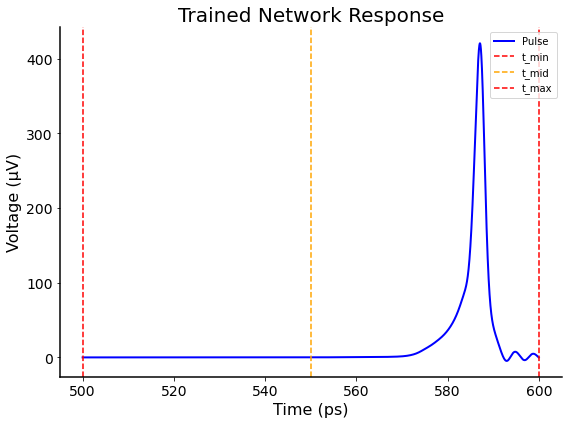

In [298]:
# Plotting Functions
fig, ax = plt.subplots(figsize=(8, 6)) # Set the size of the plot
ax.plot(ts[50000:60000], v2[50000:60000],linewidth=2, color='blue', label="Pulse") # Set the linewidth and color of the line
ax.set_xlabel('Time (ps)', fontsize=16) # Set the label and font size of the x-axis [50000:60000]
ax.set_ylabel('Voltage (ÂµV)', fontsize=16) # Set the label and font size of the y-axis
ax.tick_params(axis='both', which='major', labelsize=14) # Set the font size of the tick labels
ax.spines['top'].set_visible(False) # Remove the top axis spines
ax.spines['right'].set_visible(False) # Remove the right axis spines
ax.spines['bottom'].set_linewidth(1.5) # Increase the linewidth of the bottom axis spine
ax.spines['left'].set_linewidth(1.5) # Increase the linewidth of the left axis spine
ax.set_title('Trained Network Response', fontsize=20) 
ax.axvline(x=500, color='r', linestyle='--', label="t_min")
ax.axvline(x=550, color='orange', linestyle='--', label="t_mid")
ax.axvline(x=600, color='r', linestyle='--', label="t_max")
ax.legend()

plt.tight_layout() # Make sure everything fits in the plot area
#plt.savefig('my_plot.png', dpi=300) # Save the plot as a high-resolution PNG file
plt.show()

In [299]:
#Check the time the first spike happened
time_to_first_spike(scr.script(),params, 0, runthemean=False) 

5.870899999994479e-10

In [300]:
#Naive first check that the network is not doing something odd, TFFS would look at the absolute difference
if time_to_first_spike(scr.script(),params, 20000, runthemean=False) < 545e-12:
    print('XOR output is 0')
else:
    print('XOR output is 1')

XOR output is 1


In [301]:
#Loss test
t_desired = 5.0e-12
L1_at_point(params, scr, t_desired, 20000, runthemean=False)

5.82089999999448e-10

In [303]:
#Function for finding unitless time units
#Assuming WRSpice resolution of 0.01ps
def timestep_desired_helper(time_in_nanoseconds):
    output = time_in_nanoseconds * 1e5
    return output

In [304]:
timestep_desired_helper(0.56)

56000.00000000001

In [320]:
# Update weights based on gradients, calculate accuracy for current weights, and append accuracy to accuracy list
# Also applies a weight regularizer algorithm to ensure weights do not exceed a certain range
loss_list = []
accuracy_list = []
def take_two_gradients(input_linspace, prime, t_desired, learning_rate, number_skips, parameter_linspace, normalizer):
    weight0 = parameter_linspace[0]
    weight1 = parameter_linspace[1]

    params = {'weight0':parameter_linspace[0],'weight1':parameter_linspace[1],
    'input0':input_linspace[0],'input1':input_linspace[1]}
    
    F = L1_at_point(params, scr, t_desired, number_skips, runthemean=False) * normalizer
    params0 = {'weight0':weight0 + learning_rate,'weight1':weight1,
                     'input0':input_linspace[0],'input1':input_linspace[1]}

    params1 = {'weight0':weight0,'weight1':weight1 + learning_rate,
                     'input0':input_linspace[0],'input1':input_linspace[1]}

    F_prime0 = L1_at_point(params0, scr, t_desired, number_skips, runthemean=False)  * normalizer
    F_prime1 = L1_at_point(params1, scr, t_desired, number_skips, runthemean=False)  * normalizer
    loss_list.append(F[0])
    
    gradient0 = (F_prime0 - F) / prime
    gradient1 = (F_prime1 - F) / prime
    
    #Find Loss
    print('The loss is' + ' ' + str(F))
    weight0 = weight0 - gradient0 * learning_rate
    weight1 = weight1 - gradient1 * learning_rate


    #Update weights
    weight0 = weight0[0]
    weight1 = weight1[0]
    parameter_linspace = [weight0, weight1]

    #Accuracy calculation for current weights (not updated ones!), still using naive time checking for ease of coding
    t_predicted = time_to_first_spike(scr.script(),params, 20000, runthemean=False)
    if t_predicted < 545e-12:
        print('XOR prediction is 0')
        t_predicted = 0
    else:
        print('XOR prediction is 1')
        t_predicted = 1
   
    if t_desired[0] < 545e-12:
        print('XOR should be 0')
        t_desired = 0
    else:
        print('XOR should be 1')
        t_desired = 1

    if t_predicted == t_desired:
        accuracy = 1
    else:
        accuracy = 0
    
    accuracy_list.append(accuracy)
    print('The accuracy is'+ ' ' + str(accuracy))
    

    #weight regularizer algorithm
    for i in range(len(parameter_linspace)):
        if parameter_linspace[i] < -8:
            parameter_linspace[i] = -8  # set to minimum value
        elif parameter_linspace[i] > 8:
            parameter_linspace[i] = 8  # set to maximum value

    print('The weight values are' + ' ' + str(parameter_linspace))
    return parameter_linspace
    

In [321]:
# Create input_list and t_desired_list for training data
# Initialize weight parameters at random for the first epoch
# Loop through remaining epochs and call take_two_gradients to update weights based on training data

input_list = [[500,500],[500,552.45],[552.45,500],[552.45,552.45]] * 10
t_desired_list = [[530e-12],[550e-12],[550e-12],[590e-12]] * 10
def gradient_descent_runner(input_list, t_desired_list, learning_rate, batches, prime, normalizer):
    number_skips = 0 #20000
    batch = 0
    input_linspace = input_list[batch]
    t_desired = t_desired_list[batch]
    start = rng.integers(low=0, high=9, size=2) #Initialize weights at random
    print('Batch: 0')
    a = take_two_gradients(input_linspace, prime, t_desired, learning_rate, number_skips, start, normalizer)
    batch = 1
    while batch < batches:
        print('Batch: ' + str(batch))
        t_desired = t_desired_list[batch]
        input_linspace = input_list[batch]
        a = take_two_gradients(input_linspace, prime, t_desired, learning_rate, number_skips, a, normalizer)
        batch = batch + 1
    return a
    

In [322]:
# Define hyperparameters for training the model
# Call gradient_descent_runner function to train the model and return updated weight parameters

learning_rate = 0.1 #adjusts how quickly the weights change original 0.001
prime = 1e-3 #divides gradient which is difference between times original 1e-6
normalizer = 1e10 #adding this to prevent vanishing gradients when using L1 loss with our scheme (because of picosecond scale)
batch = 4 #number of batches
gradient_descent_runner(input_list, t_desired_list, learning_rate, batch, prime, normalizer)

Batch: 0
The loss is [0.0439]
XOR prediction is 0
XOR should be 0
The accuracy is 1
The weight values are [4.069999999999877, 7.049999999999912]
Batch: 1
The loss is [0.0109]
XOR prediction is 1
XOR should be 1
The accuracy is 1
The weight values are [4.83999999999852, 7.049999999999912]
Batch: 2
The loss is [0.1148]
XOR prediction is 0
XOR should be 1
The accuracy is 0
The weight values are [4.83999999999852, 6.970000000000052]
Batch: 3
The loss is [0.0374]
XOR prediction is 1
XOR should be 1
The accuracy is 1
The weight values are [4.769999999998643, 6.92000000000014]


[4.769999999998643, 6.92000000000014]

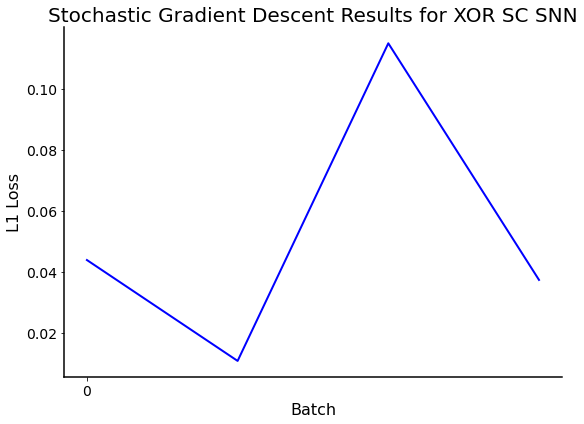

In [325]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(8, 6)) # Set the size of the plot
ax.plot(loss_list,linewidth=2, color='blue', ) # Set the linewidth and color of the line
ax.set_xlabel('Batch', fontsize=16) # Set the label and font size of the x-axis
ax.set_ylabel('L1 Loss', fontsize=16) # Set the label and font size of the y-axis
ax.tick_params(axis='both', which='major', labelsize=14) # Set the font size of the tick labels
ax.spines['top'].set_visible(False) # Remove the top axis spines
ax.spines['right'].set_visible(False) # Remove the right axis spines
ax.spines['bottom'].set_linewidth(1.5) # Increase the linewidth of the bottom axis spine
ax.spines['left'].set_linewidth(1.5) # Increase the linewidth of the left axis spine
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))

ax.set_title('Stochastic Gradient Descent Results for XOR SC SNN', fontsize=20) 

plt.tight_layout() # Make sure everything fits in the plot area
#plt.savefig('plotname.png', dpi=300) # Save the plot as a high-resolution PNG file
plt.show()

In [331]:
#Get the accuracy
sum(accuracy_list) / batch

0.75